<a href="https://colab.research.google.com/github/lemacdonald/CoordinateNetworksExercise/blob/main/CoordinateNetworkExercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Coordinate networks and their peculiarities**

In this exercise, we will train a simple neural network to encode the following "peppers" image:

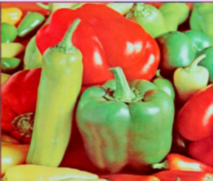

First, import the required packages.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda:0"

Now, convert the png image into two datasets: a training set (consisting of pixels whose coordinate sum is even) and a test set (consisting of pixels whose coordinate sum is odd).

In [61]:
# convert image to tensor
img = Image.open('peppersddown.png')
img = np.array(img)[:,:,:3]
total_targets = torch.as_tensor(img, dtype=torch.float32)/256.0

w = img.shape[0] # img width
h = img.shape[1] # img height

# create coordinate datasets
x = torch.linspace(0, (w-1)/w, w) # x coordinate
y = torch.linspace(0, (h-1)/h, h) # y coordinate
total_data = torch.stack(torch.meshgrid(x,y)).permute(1,2,0).to(device) # tensor of (x,y) coordinates
# now, total_data[i,j] is the (i,j)^th coordinate corresponding to the pixel value total_target[i,j]

# next, we split into train and test sets
train_data = total_data[(w*total_data[:,:,0] + h*total_data[:,:,1])%2 == 0].to(device)
train_targets = total_targets[(w*total_data[:,:,0] + h*total_data[:,:,1])%2 == 0].to(device)

test_data = total_data[(w*total_data[:,:,0] + h*total_data[:,:,1])%2 == 1].to(device)
test_targets = total_targets[(w*total_data[:,:,0] + h*total_data[:,:,1])%2 == 1].to(device)

Now set up and initialise the network:

In [75]:
width = 100

# network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

net = Net().to(device)

Finally, train the network on the training set. We use the square loss with full-batch gradient descent, and store the loss at each epoch to plot later.

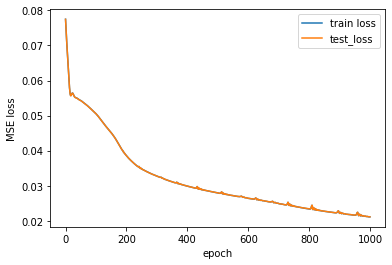

In [76]:
# optimiser
optimizer = optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-8)
criterion = nn.MSELoss()

# training loop
epoch = 1000
x = np.arange(epoch)
y_train = np.zeros(epoch)
y_test = np.zeros(epoch)

for i in range(epoch):
  with torch.no_grad():
    output_test = net(test_data)
    loss_test = criterion(output_test, test_targets)
    y_test[i] = loss_test

  optimizer.zero_grad()
  output = net(train_data)
  loss = criterion(output, train_targets)
  y_train[i] = loss
  loss.backward()
  optimizer.step()

plt.plot(x,y_train, label="train loss")
plt.plot(x,y_test, label="test_loss")
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.show()

The train and test curves look pretty much identical - our network generalises well!  Finally, let's see how well our network reproduces the image visually (you can look at the saved image by clicking on the folder icon on the left hand side of colab).

In [64]:
with torch.no_grad():
    output = net(total_data).cpu().numpy()
    outputrescale = (output*256).astype(np.uint8)
    data = Image.fromarray(outputrescale)
    data.save('reprod.png')

(181, 213, 3)
uint8


Doesn't look great.  We could improve this by adding more layers and training for longer (give this a go if you like).  Instead, we'll be a bit cleverer.  We will embed our coordinates in a higher dimensional space using *positional encoding*.  With the extra "elbow room" afforded by the higher dimensionality, our network will be able to better fit the detail of the image without needing additional capacity.

The positional encoding map is defined by fixing some even natural number $d$ (the embedding dimension), a $d/2$-tuple $\mu$ of real numbers, and a positive number $\sigma$, and sending coordinates $(x,y)$ to the new tuple
\begin{equation}
(e^{-\frac{(x-\mu_{1})^2}{\sigma^2}},\dots,e^{-\frac{(x-\mu_{d/2})^2}{\sigma^2}},e^{-\frac{(y-\mu_{1})^2}{\sigma^2}},\dots,e^{-\frac{(y-\mu_{d/2})^2}{\sigma^2}})
\end{equation}
The factors determining what sorts of embeddings are "good" have been studied by the team at AIML (https://arxiv.org/abs/2107.02561), where this specific embedding was introduced.

In [79]:
def gaussian_embedding(x, mu, sig):
    emb1 = (-0.5*(x[:,0].unsqueeze(1)-mu)**2/(sig**2)).exp() # embed x coordinate
    emb2 = (-0.5*(x[:,1].unsqueeze(1)-mu)**2/(sig**2)).exp() # embed y coordinate
    emb = torch.cat([emb1, emb2], 1)
    emb = emb/(emb.norm(dim=1).max())
    return emb

# we will embed into 200-dimensional space
embedding_dim = 200

# set up the Gaussian means
mu = torch.zeros((1,int(embedding_dim/2))).to(device)
for i in range(int(embedding_dim/2)):
    mu[0,i] = 2*i/embedding_dim

# the Gaussian width
sig = 0.07

# embed the data
train_data_emb = gaussian_embedding(train_data, mu, sig)
test_data_emb = gaussian_embedding(test_data, mu, sig)
total_data_emb = gaussian_embedding(total_data.flatten(0,1), mu, sig)

Now we need to modify our network to account for the higher dimensional inputs.

In [82]:
width = 100

# network
class Net_emb(nn.Module):
    def __init__(self):
        super(Net_emb, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

net_emb = Net_emb().to(device)

Finally - let's train and see what happens.

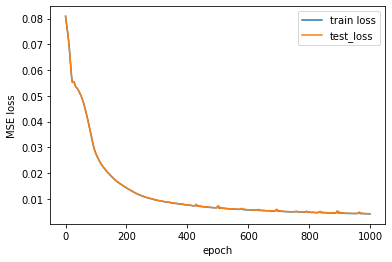

In [83]:
# optimiser
optimizer = optim.Adam(net_emb.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-8)
criterion = nn.MSELoss()

# training loop
epoch = 1000
x = np.arange(epoch)
y_train = np.zeros(epoch)
y_test = np.zeros(epoch)

for i in range(epoch):
  with torch.no_grad():
    output_test = net_emb(test_data_emb)
    loss_test = criterion(output_test, test_targets)
    y_test[i] = loss_test

  optimizer.zero_grad()
  output = net_emb(train_data_emb)
  loss = criterion(output, train_targets)
  y_train[i] = loss
  loss.backward()
  optimizer.step()

plt.plot(x,y_train, label="train loss")
plt.plot(x,y_test, label="test_loss")
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.show()

with torch.no_grad():
    output = net_emb(total_data_emb).reshape(w,h,3).cpu().numpy()
    outputrescale = (output*256).astype(np.uint8)
    data = Image.fromarray(outputrescale)
    data.save('reprod_emb.png')

Success!